In [1]:
import os

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.morphology import label, binary_opening, disk

from sklearn.model_selection import train_test_split
from PIL import Image

import gc
import datetime


gc.enable()

import keras.backend as K

from keras.layers import *

from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [139]:
image_path = 'image_data/train_v2/'
test_image = 'image_data/test_v2/'

csv_dataset = 'csv_data/train_ship.csv'

exclude_list = ['6384c3e78.jpg', ] # destroyed images
original_img_size = (768, 768) # image shape

LR = 0.0001 # learning rate

BATCH_SIZE = 16 # batch size

# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 1200
MAX_TRAIN_EPOCHS = 3

weight_path="{}_weights.hdf5".format('seg_model')

In [140]:
df = pd.read_csv(csv_dataset)

df = df[~df['ImageId'].isin(exclude_list)] #deleting desroyed files
df['ships'] = df.groupby(['ImageId'])['ImageId'].transform('count') # counting of ships for each image_file
df.loc[df['EncodedPixels'].isnull().values,'ships'] = 0 # nullable missing data

# calculation of files' sizes
df['file_size_kb'] = df['ImageId'].map(lambda image: 
                                       os.stat(os.path.join(image_path, image)).st_size/1024
                                       
df = df[df['file_size_kb'] > 60] # filtering by file_size

In [141]:
"""
Data sampling
1: select images with shops and without ships
2: add column 'has_ship' for data stratification
"""
imgs_w_ships = df[df['ships'] > 0]
imgs_wo_ships = df[df['ships'] == 0].sample(23000, random_state=6978)

selected_imgs = pd.concat((imgs_w_ships, imgs_wo_ships))

selected_imgs['has_ship'] = selected_imgs['ships'] > 0

Text(0.5, 1.0, 'after proccessing')

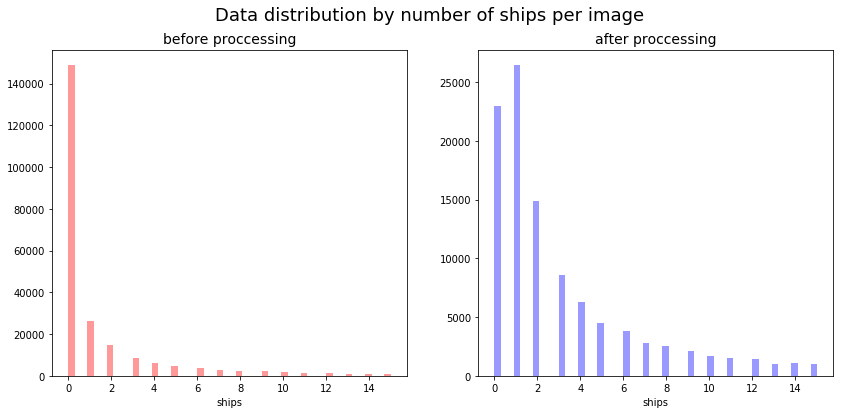

In [142]:
"""
visualization of data distribution
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

fig.suptitle('Data distribution by number of ships per image', fontsize=18)

sns.distplot(df['ships'], kde=False, color="r", ax=axes[0])
sns.distplot(selected_imgs['ships'], kde=False, color="b", ax=axes[1])

axes[0].set_title('before proccessing', fontsize=14)
axes[1].set_title('after proccessing', fontsize=14)

In [143]:
"""
Splitting data into training and validation samples
"""

train_imgs, val_imgs = train_test_split(selected_imgs,
                                        test_size=0.05,
                                        stratify=selected_imgs['has_ship'],
                                        random_state=69278)
# selecting unique filenames to avoid overfitting
train_fnames = np.unique(train_imgs['ImageId'].values)
val_fnames = np.unique(val_imgs['ImageId'].values)

_, train_fnames = train_test_split(train_fnames, test_size=0.95, random_state=6978)
_, val_fnames = train_test_split(val_fnames, test_size=0.95, random_state=6978)

In [145]:
reduced_df = selected_imgs[['ImageId', 'EncodedPixels']]

train_df = reduced_df[reduced_df['ImageId'].isin(train_fnames)]
val_df = reduced_df[reduced_df['ImageId'].isin(val_fnames)]

In [ ]:
del selected_imgsed_imgsed_imgs, df # delete unnececollectct data
gc.collect() # freeing up memory

In [146]:
def rle_decoder(mask_rle, shape=(768, 768)):
    """
    Function for decoding target image
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks2image(in_mask_list):
    """
    Function for creating multi-layers mask
    that consist some ships on ine image
    """
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decoder(mask)
    return all_masks


In [147]:
class CustomDataGenerator:
    '''
    Class CustomDatagenerator
    __init__ - constructor for creating a instance of class
    __len__ - method for getting size of dataset
    batch_creator - method for creating batches
    generate - control function that manipulates the distribution of data
    '''
    def __init__(self, df_x, df_y,
                 valid_df=None,
                 batch_size=16,
                 image_path=None,
                 mask2image=None,
                 augmentator=None):
        
        self.df_x = df_x # list of image filenames which will use for training
        self.df_y = df_y # dataframe of image filenames and their encoded masks
        self.valid_df = valid_df # dataframe of images and their masks
        self.batch_size = batch_size # number of samples for one step
        self.image_path = image_path # path to train images
        self.augmentator = augmentator # image augmentation operations
        
    def __len__(self):
        return int(np.ceil(len(self.df_x) / float(self.batch_size)))
    
    def batch_creator(self, batch_fname, batch_df):
        height, width = original_img_size # take height and width for shape of input
        input_images = np.zeros((self.batch_size, height, width, 3))
        target_images = np.zeros((self.batch_size, height, width, 1))
        for i, img_name in enumerate(batch_fname):
            input_images[i, ...] = imread(os.path.join(image_path, img_name))
            rle = batch_df[batch_df['ImageId'] == img_name]['EncodedPixels'].values
            target_images[i, ...] = np.expand_dims(masks2image(rle), axis = 2)
        return (input_images, target_images)
    
    def generate(self):
        np.random.shuffle(self.df_x)
        num_of_batches = self.__len__()
        for batch in range(num_of_batches):
            batch_fname = np.random.choice(self.df_x, self.batch_size)
#             print(batch_fname)
            batch_df = self.df_y[self.df_y['ImageId'].isin(batch_fname)]
            yield self.batch_creator(batch_fname, batch_df)

In [148]:
"""
Creating training and validation generators
"""

train_gen = CustomDataGenerator(train_fnames, train_df, image_path=image_path, batch_size=BATCH_SIZE)
val_gen = CustomDataGenerator(val_fnames, val_df, image_path=image_path, batch_size=BATCH_SIZE)

t_gen = train_gen.generate()
v_gen = val_gen.generate()

In [149]:
# args for keras ImageDataGenerator

dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 7,
               width_shift_range = 0.07,
               height_shift_range = 0.07,
               shear_range = 0.01,
               horizontal_flip = True, 
               vertical_flip = True,
               fill_mode = 'nearest',
               data_format = 'channels_last')
    
image_gen = ImageDataGenerator(**dg_args) # creating instance of ImageDataGenerator

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # creating augmented generator of input and target data
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = image_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        gc.collect()

        yield next(g_x)/255.0, next(g_y)

In [150]:
"""
Added callbacks for controling proccess of training
checkpoint - saves best result of training
reduceLROnPlat - reduces learning rate when a metric has stopped improving
early - responses for stopping of model when a quality of model has stopped improving
"""

checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20)

callbacks_list = [checkpoint, reduceLROnPlat, early] # list of callbacks

In [154]:
'''
Verification of generators for correctness of result
'''
x, y = next(v_gen)
x = x/255.0

idx = BATCH_SIZE - 1

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6), sharex=True)
y2 = y1[:,:,:,0][idx]

ax1.imshow(x[idx])
ax2.imshow(y2)

In [157]:
model = load_model('U-Net.h5') # loading model

/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [158]:
smooth = 1
def dice_score(y_pred, y_target):
    # dice score for testing valid accuracy
    comm = K.sum(y_pred * y_target)
    return (comm * 2.0 + smooth)/(K.sum(y_pred) + K.sum(y_target) + smooth)

def bce_dice_loss(y_pred, y_target):
    # dice loss metric
    return binary_crossentropy(y_target, y_pred) + (1-dice_score(y_pred, y_target))

In [159]:
"""
function for training network and then getting logs
"""

def fit():
    model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=bce_dice_loss, metrics=['binary_accuracy', dice_score])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(t_gen)
    loss_history = [model.fit_generator(aug_gen,
                                        steps_per_epoch=step_count,
                                        epochs=MAX_TRAIN_EPOCHS,
                                        validation_data=v_gen,
                                        validation_steps = 10,
                                        callbacks=callbacks_list,
                                        )]
    return loss_history

In [160]:
loss_history = fit()

Epoch 1/3
1200/1200 [==============================] - 4354s 4s/step - loss: 2.0904 - binary_accuracy: 0.9611 - dice_score: 0.1389 - val_loss: 11.5548 - val_binary_accuracy: 0.3448 - val_dice_score: 0.0105

Epoch 00001: val_loss improved from inf to 11.55475, saving model to seg_model_weights.hdf5
Epoch 2/3
1200/1200 [==============================] - 4277s 4s/step - loss: 0.7733 - binary_accuracy: 0.9930 - dice_score: 0.3450 - val_loss: 1.7316 - val_binary_accuracy: 0.9498 - val_dice_score: 0.0799

Epoch 00002: val_loss improved from 11.55475 to 1.73159, saving model to seg_model_weights.hdf5
Epoch 3/3
1200/1200 [==============================] - 4277s 4s/step - loss: 0.7112 - binary_accuracy: 0.9935 - dice_score: 0.3897 - val_loss: 3.2778 - val_binary_accuracy: 0.8564 - val_dice_score: 0.0447

Epoch 00003: val_loss did not improve from 1.73159

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [163]:
model.save_weights('model.h5')